In [2]:
import numpy as np
import sympy
from sympy import Expr, Eq, latex, plot_implicit, tan, cot
from sympy.core import S, pi, sympify
from sympy.core.logic import fuzzy_bool
from sympy.core.numbers import Rational, oo
from sympy.core.compatibility import ordered
from sympy.core.symbol import Dummy, _uniquely_named_symbol, _symbol
from sympy.simplify import simplify, trigsimp
from sympy.functions.elementary.miscellaneous import sqrt, Max
from sympy.functions.elementary.trigonometric import cos, sin
from sympy.functions.special.elliptic_integrals import elliptic_e
from sympy.geometry.exceptions import GeometryError
from sympy.geometry.line import Ray2D, Segment2D, Line2D, LinearEntity3D
from sympy.polys import DomainError, Poly, PolynomialError
from sympy.polys.polyutils import _not_a_coeff, _nsort
from sympy.solvers import solve
from sympy.solvers.solveset import linear_coeffs
from sympy.utilities.misc import filldedent, func_name
from sympy.geometry.entity import GeometryEntity, GeometrySet
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Segment
from sympy.geometry.util import idiff
import matplotlib.pyplot as plt
%matplotlib inline

# Занятие 15
# Алгебра
## Кривые второго порядка на плоскости: гипербола

In [131]:
class Hyperbola(GeometrySet):
    """
     Attributes
    ==========
    center
    hradius
    vradius
    eccentricity
    periapsis
    focus_distance
    foci
    ==========
    конструктор __new__
    скопирован из Эллипса,
    изменена формула для  hradius и vradius через эсцентриситет
    """
    def __new__(
        cls, center=None, hradius=None, vradius=None, eccentricity=None, **kwargs):
        hradius = sympify(hradius)
        vradius = sympify(vradius)

        eccentricity = sympify(eccentricity)

        if center is None:
            center = Point(0, 0)
        else:
            center = Point(center, dim=2)

        if len(center) != 2:
            raise ValueError('The center of "{0}" must be a two dimensional point'.format(cls))

        if len(list(filter(lambda x: x is not None, (hradius, vradius, eccentricity)))) != 2:
            raise ValueError(filldedent('''
                Exactly two arguments of "hradius", "vradius", and
                "eccentricity" must not be None.'''))

        if eccentricity is not None:
            if hradius is None:
                hradius = vradius/sqrt( eccentricity**2 - 1)
            elif vradius is None:
                vradius = hradius*sqrt( eccentricity**2 - 1)

        if hradius == 0:
            return "Line"
        if vradius == 0:
            return "Rays"
        return GeometryEntity.__new__(cls, center, hradius, vradius, **kwargs)
    
    @property
    def ambient_dimension(self):
        return 2
    
    @property
    def center(self):
        return self.args[0]

    @property
    def hradius(self):
        return self.args[1]
    
    @property
    def vradius(self):
        return self.args[2]
    @property
    def focus_distance(self):
        return sqrt(self.hradius**2 + self.vradius**2)
    
    @property
    def eccentricity(self):
        """The eccentricity of the ellipse."""
        return self.focus_distance/self.hradius
    
    @property
    def periapsis(self):
        """The apoapsis of the hyperbola.
        The smallest distance between the focus and the contour."""
        return self.focus_distance-self.hradius
    @property
    def foci(self):
        return (self.center + Point(-self.focus_distance, 0), self.center + Point(self.focus_distance, 0))
    
    @property
    def major(self):
        return self.hradius
    
    @property
    def minor(self):
        return self.vradius
    
    def equation(self, x='x', y='y', _slope=None, equation=False):
        """
        Returns the equation of a hyperbola aligned with the x and y axes;
        when slope is given, the equation returned corresponds to a hyperbola 
        with a major axis having that slope.
        Parameters
        ==========
        x : str, optional
            Label for the x-axis. Default value is 'x'.
        y : str, optional
            Label for the y-axis. Default value is 'y'.
        _slope : Expr, optional
                The slope of the major axis. Ignored when 'None'.
        Returns
        =======
        equation : sympy expression   """

        x = _symbol(x, real=True)
        y = _symbol(y, real=True)

        dx = x - self.center.x
        dy = y - self.center.y

        if _slope is not None:
            L = (dy - _slope*dx)**2
            l = (_slope*dy + dx)**2
            h = 1 + _slope**2
            a = h*self.major**2
            b = h*self.minor**2
            res= l/a - L/b 

        else:
            t1 = (dx/self.hradius)**2
            t2 = (dy/self.vradius)**2
            res = t1 - t2 
        if not equation:
            return res - 1
        else:
            return Eq(res, 1)      
        
    def asymptote(self, x='x', y='y', alpha=None, equation=False):
        if alpha == None:            
            return (
                self.center.y + self.vradius / self.hradius * (_symbol(x) - self.center.x) - _symbol(y),
                self.center.y - self.vradius / self.hradius * (_symbol(x) - self.center.x) - _symbol(y),
            )
        else:
            k1 = (self.vradius + self.hradius * sympy.tan(alpha)) / (self.hradius - self.vradius * sympy.tan(alpha))
            k2 = (-self.vradius + self.hradius * sympy.tan(alpha)) / (self.hradius + self.vradius * sympy.tan(alpha))
            return (
                -_symbol(y) + self.center.y + k1 * (_symbol(x) - self.center.x),
                -_symbol(y) + self.center.y + k2 * (_symbol(x) - self.center.x)
            )        
        
    def directrix(self, x='x', y='y', alpha=None, equation=False):        
        if alpha == None:
            return (
                self.center.x + self.hradius**2 / self.focus_distance - _symbol(x),
                self.center.x - self.hradius**2 / self.focus_distance - _symbol(x),
            )
        else:
            return (            
                -_symbol(y) + self.center.y - sympy.cot(alpha)*(_symbol(x) - self.center.x) + self.hradius**2 / self.focus_distance * sqrt(1 + sympy.cot(alpha)),
                -_symbol(y) + self.center.y - sympy.cot(alpha)*(_symbol(x) - self.center.x) - self.hradius**2 / self.focus_distance * sqrt(1 + sympy.cot(alpha)),
            )

# Занятие 15
# Алгебра
### Задание 1.
Построить гиперболу с центром в точке А(1, 2), полуосями 12 и 5. Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis и уравнение гиперболы.

In [133]:
A = Point(1, 2)
hyp = Hyperbola(center=A, hradius=12, vradius=5)

display(
    hyp.eccentricity,
    hyp.focus_distance,
    hyp.foci,
    hyp.periapsis,
    hyp.equation(),
)

13/12

13

(Point2D(-12, 2), Point2D(14, 2))

1

(x/12 - 1/12)**2 - (y/5 - 2/5)**2 - 1

### Задание 2.
Добавить в описание класса гипербол методы 

asymptote(self, x='x', y='y', equation=False)

directrix(self, x='x', equation=False)

Для гиперболы Задания 1 вывести на экран уравнения асимптот и директрис.

(5*x/12 - y + 19/12, -5*x/12 - y + 29/12)

(157/13 - x, -x - 131/13)

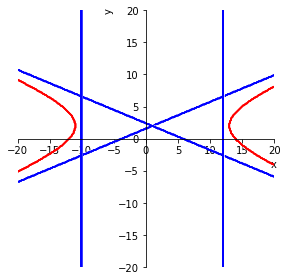

In [134]:
display(
    hyp.asymptote(),
    hyp.directrix(),
)

x, y = sympy.symbols("x y")
eq = hyp.equation(x=x, y=y)
rng = ((x, -20, 20), (y, -20, 20))
p = plot_implicit(eq, *rng, line_color='r', show=False, aspect_ratio=(1,1), adaptive=False)
p.append(plot_implicit(hyp.asymptote()[0], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.append(plot_implicit(hyp.asymptote()[1], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.append(plot_implicit(hyp.directrix()[0], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.append(plot_implicit(hyp.directrix()[1], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.show()

### Задание 3.
Вывести на экран уравнение гиперболы из задания 1 с поворотом на 30 градусов против часовой стрелки относительно ее центра.
Изобразить повернутую гиперболу с помощью plot_implicit.

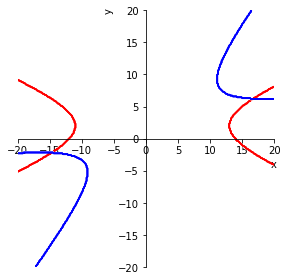

In [135]:
x, y = sympy.symbols("x y")
rng = ((x, -20, 20), (y, -20, 20))
p = plot_implicit(hyp.equation(x=x, y=y), *rng, line_color='r', show=False, aspect_ratio=(1,1), adaptive=False)
p.append(plot_implicit(hyp.equation(x=x, y=y, _slope= tan(sympy.rad(30))), *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.show()

## Уравнения директрис и асимптот при повороте на угол $\alpha$
Пусть  $a$ - горизонтальная полуось, $c$ - фокусное расстояние, $x_0$ - горизонтальная координата центра гиперболы, тогда уравнение директрис 
$$
x = x_0 \pm \frac{a^2}{c}
$$
При повороте на угол $\alpha$ получается уравнение
$$
y = y_0 -{\rm ctg} \alpha(x - x_0) \pm \frac{a^2}{c}\sqrt{1 + {\rm ctg} \alpha}
$$
Уравнение асимптоты
$$
y = y_0 \pm \frac{b}{a}(x - x_0)
$$
При повороте на угол $\alpha$ получаются уравнения
\begin{align*}
y_1 = y_0 + k_1(x - x_0), \quad 
y_2 = y_0 + k_2(x - x_0), \\ 
k_1 = \frac{b + a{\rm tg} \alpha}{a - b{\rm tg} \alpha},\quad 
k_2 = \frac{-b + a{\rm tg} \alpha}{a + b{\rm tg} \alpha}
\end{align*}
### Задание 4.
Изобразить гиперболу Задания 3 (т.е. повернутую на угол) и ее асимптоты и директрисы на одном графике plot_implicit.

(-y + (5 + 4*sqrt(3))*(x - 1)/(12 - 5*sqrt(3)/3) + 2,
 -y + (-5 + 4*sqrt(3))*(x - 1)/(5*sqrt(3)/3 + 12) + 2)

(-y - sqrt(3)*(x - 1) + 2 + 144*sqrt(1 + sqrt(3))/13,
 -y - sqrt(3)*(x - 1) - 144*sqrt(1 + sqrt(3))/13 + 2)

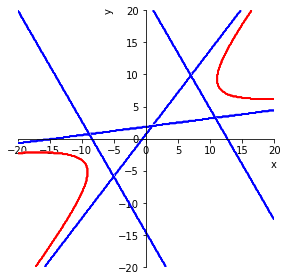

In [136]:
x, y = sympy.symbols("x y")
angle = sympy.rad(30)

display(
    hyp.asymptote(alpha=alpha),
    hyp.directrix(alpha=alpha),
)

eq = hyp.equation(x=x, y=y, _slope=sympy.tan(angle))
rng = ((x, -20, 20), (y, -20, 20))
p = plot_implicit(eq, *rng, line_color='r', show=False, aspect_ratio=(1,1), adaptive=False)
p.append(plot_implicit(hyp.asymptote(alpha=alpha)[0], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.append(plot_implicit(hyp.asymptote(alpha=alpha)[1], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.append(plot_implicit(hyp.directrix(alpha=alpha)[0], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.append(plot_implicit(hyp.directrix(alpha=alpha)[1], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.show()

###  Индивидуальное задание. Вариант 11.
Определить гиперболу с центром в точке $O$, полуосями $a$ и $b$.  Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis, уравнение гиперболы, уравнения асимптот и директрис. 

Изобразить гиперболу, повернутую на $\alpha$ градусов против часовой стрелки относительно ее центра, соответствующие асимптоты и директрисы. Вывести на экран уравнения повернутой гиперболы, соответствующих асимптот и директрис.

O	| a |	b	| угол поворота	| направление поворота
:-:|:-:|:-:|:-:|:-:
Point2D(2, -4)	|14|	8|	$\pi / 3$|	по часовой стрелке

sqrt(65)/7

2*sqrt(65)

(Point2D(2 - 2*sqrt(65), -4), Point2D(2 + 2*sqrt(65), -4))

-14 + 2*sqrt(65)

(x/14 - 1/7)**2 - (y/8 + 1/2)**2 - 1

(4*x/7 - y - 36/7, -4*x/7 - y - 20/7)

(-x + 2 + 98*sqrt(65)/65, -x - 98*sqrt(65)/65 + 2)

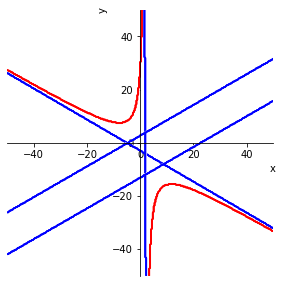

(x - sqrt(3)*(y + 4) - 2)**2/784 - (y + sqrt(3)*(x - 2) + 4)**2/256 - 1

(-y + (8 - 14*sqrt(3))*(x - 2)/(8*sqrt(3) + 14) - 4,
 -y + (-14*sqrt(3) - 8)*(x - 2)/(14 - 8*sqrt(3)) - 4)

(-y + sqrt(3)*(x - 2)/3 - 4 + 98*sqrt(65)*sqrt(1 - sqrt(3)/3)/65,
 -y + sqrt(3)*(x - 2)/3 - 98*sqrt(65)*sqrt(1 - sqrt(3)/3)/65 - 4)

In [146]:
hyp = Hyperbola(center=Point(2, -4), hradius=14, vradius=8)

display(
    hyp.eccentricity,
    hyp.focus_distance,
    hyp.foci,
    hyp.periapsis,
    hyp.equation(),
    hyp.asymptote(),
    hyp.directrix(),
)

alpha = -sympy.pi / 3

eq = hyp.equation(x=x, y=y, _slope=sympy.tan(alpha))
rng = ((x, -50, 50), (y, -50, 50))
p = plot_implicit(eq, *rng, line_color='r', show=False, aspect_ratio=(1,1), adaptive=False)
p.append(plot_implicit(hyp.asymptote(alpha=alpha)[0], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.append(plot_implicit(hyp.asymptote(alpha=alpha)[1], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.append(plot_implicit(hyp.directrix(alpha=alpha)[0], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.append(plot_implicit(hyp.directrix(alpha=alpha)[1], *rng, aspect_ratio=(1,1), show=False, adaptive=False)[0])
p.show()

display(
    eq,
    hyp.asymptote(alpha=alpha),
    hyp.directrix(alpha=alpha)
)